# Regularization
정규화라고 표기되기도 하지만 normalization이 아니라 **오버피팅을 늦추고 모델이 학습 데이터로부터 적절한 특징들을 학습하여 일반화 오차를 낮춰줄 수 있는 기법** 을 의미한다.  
- 데이터를 통한 졍규화
    - Data Augmentation
- 손실 함수를 통한 정규화
    - Weight Decay (가중치감쇠)
- 신경망 계층을 통한 정규화
    - dropout
    - batch normalization
    - layer normalization
- 학습/추론 방식을 통한 정규화
    - Early stopping
    - Bagging & Ensemble

## 14.6 정규화 실습
### 1. 데이터 준비

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

In [8]:
train = datasets.MNIST('../data/paper_review', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('../data/paper_review', train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [9]:
y = train.targets

x = train.data.float() / 255.
x = x.view(x.size(0), -1)

# 2차원 이미지를 1차원 벡터로 변경
input_size = x.size(-1)
output_size = int(max(y)) + 1

print('x, y shape', x.shape, y.shape)
print('input, output size', input_size, output_size)

x, y shape torch.Size([60000, 784]) torch.Size([60000])
input, output size 784 10


In [12]:
# train, valid split ratios
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print(train_cnt, valid_cnt, test_cnt)

48000 12000 10000


In [13]:
# train, valid split
indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [(test.targets)]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


### 2. 학습 코드 구현

In [18]:
class Block(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.2):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__()
        def get_regularizer(use_batch_norm, size):
            if use_batch_norm:
                return nn.BatchNorm1d(size)
            else:
                return nn.Dropout(dropout_p)
            
        self.block = nn.Sequential(nn.Linear(input_size, output_size),
                                   nn.LeakyReLU(),
                                   get_regularizer(use_batch_norm, output_size),
                                  )

    def forward(self, x):
        y = self.block(x)
        return y

In [19]:
class MyModel(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.2):
        
        super().__init__()
        self.layers = nn.Sequential(Block(input_size, 500, use_batch_norm, dropout_p),
                                    Block(500, 250, use_batch_norm, dropout_p),
                                    Block(250, 125, use_batch_norm, dropout_p),
                                    Block(125, 25, use_batch_norm, dropout_p),
                                    nn.Linear(25, output_size),
                                    nn.LogSoftmax(dim=-1),
                                   )
        
    def forward(self, x):
        y = self.layers(x)
        return y

In [20]:
model = MyModel(input_size, output_size, use_batch_norm=True)
model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=250, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=250, out_features=125, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=125, out_features=25, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(25, eps

In [25]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [24]:
n_epochs = 1000
batch_size = 256
early_stop = 50
lowest_loss = np.inf
lowest_epoch = np.inf
best_model = None

In [26]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss = 0
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss)
    train_loss = train_loss/len(x_)
    
    model.eval()
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
    valid_loss = valid_loss/len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i+1) % 20 == 0:
        print(f'Epoch {i}/{n_epochs}  Train Loss {train_loss:.4f}  Valid Loss {valid_loss:.4f}')
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if lowest_epoch + early_stop < i+1:
            print('Early Stop')
            break
            
print('----------Finish----------')
print(f'The best validation loss {lowest_loss} in {lowest_epoch}')
# model.load_state_dict(best_model)

Epoch 19/1000  Train Loss 0.0092  Valid Loss 0.0782
Epoch 39/1000  Train Loss 0.0024  Valid Loss 0.0849
Early Stop
----------Finish----------
The best validation loss 0.07066265113176183 in 7


### 3. 손실 곡선 확인

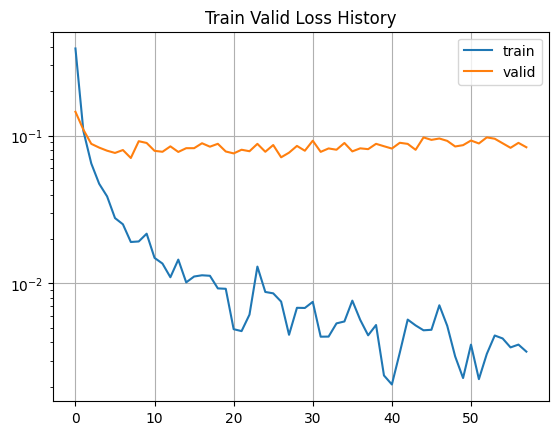

In [27]:
plt.figure()
plt.grid(True)
plt.title('Train Valid Loss History')
plt.plot(train_history, label='train')
plt.plot(valid_history, label='valid')
plt.legend()
plt.yscale('log')
plt.show()

### 4. 결과 확인

In [28]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        test_loss += loss
        y_hat += [y_hat_i]
        
test_loss = test_loss/len(x_)
y_hat = torch.cat(y_hat, dim=0)
print(f'Test Loss {test_loss:.4f}')

correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))
print(f'Test Accuracy {(correct_cnt/total_cnt):.4f}')

Test Loss 0.0923
Test Accuracy 0.9814


### ERR을 통한 상대적인 모델 개선 폭 측정

ERR = {(1-과거정확도) - (1-현재정확도)}/(1-과거정확도)